In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
# from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
import IPython.display

In [6]:
pd.set_option("display.max_row", 200)

In [20]:
df = pd.read_csv("data/all_data_aggr_nonan.csv", index_col=0)
df.drop(["appCat.weather"], inplace=True, axis=1) # only has 1 unique value

In [21]:
[(i,len(df[i].unique())) for i in list(df.columns)]

[('weekday', 7),
 ('mood', 57),
 ('circumplex.arousal', 42),
 ('circumplex.valence', 35),
 ('activity', 1051),
 ('screen', 1165),
 ('call', 25),
 ('sms', 14),
 ('appCat.builtin', 1153),
 ('appCat.communication', 1150),
 ('appCat.entertainment', 810),
 ('appCat.finance', 205),
 ('appCat.game', 185),
 ('appCat.office', 264),
 ('appCat.other', 1102),
 ('appCat.social', 956),
 ('appCat.travel', 414),
 ('appCat.unknown', 241),
 ('appCat.utilities', 420),
 ('subject_id', 27),
 ('days', 55)]

In [80]:
df = df.reindex(columns=['mood'] + list(df.columns.drop(['mood']))) # make mood first col

In [29]:
def granger_causality_matrix_aic(data, variables, test="ssr_chi2test", maxlag=12):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            # ensure time-series is stationary by first difference
            cur_data = data[[r, c]].apply(lambda x: np.diff(x)[1:], axis=0)
            min_aic = np.inf
            optimal_lag = 0
            for lag in range(1, maxlag+1):
                test_result = grangercausalitytests(cur_data, maxlag=lag, verbose=False)
                aic = np.log(test_result[lag][0][test][0])
                if aic < min_aic:
                    min_aic = aic
                    optimal_lag = lag
            if optimal_lag > maxlag:
                optimal_lag = maxlag
            test_result = grangercausalitytests(cur_data, maxlag=optimal_lag, verbose=False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(optimal_lag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [81]:
granger_matrix = granger_causality_matrix_aic(df, list(df.columns), maxlag=10)

/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_48308/728954464.py:11: RuntimeWarning: divide by zero encountered in log
  aic = np.log(test_result[lag][0][test][0])
/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_48308/728954464.py:11: RuntimeWarning: invalid value encountered in log
  aic = np.log(test_result[lag][0][test][0])
/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_48308/728954464.py:11: RuntimeWarning: divide by zero encountered in log
  aic = np.log(test_result[lag][0][test][0])
/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_48308/728954464.py:11: RuntimeWarning: invalid value encountered in log
  aic = np.log(test_result[lag][0][test][0])
/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_48308/728954464.py:11: RuntimeWarning: divide by zero encountered in log
  aic = np.log(test_result[lag][0][test][0])
/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_48308/728954464.py:11: RuntimeWarning: invalid value encou

In [82]:
rows = [i.replace("x","y") for i in list(granger_matrix.columns)]
len(granger_matrix.columns)

21

In [83]:
display(np.array(granger_matrix))

array([[1.000e+00, 1.795e-01, 8.564e-01, 6.000e-03, 1.152e-01, 1.451e-01,
        6.305e-01, 5.810e-01, 6.399e-01, 6.918e-01, 4.542e-01, 9.945e-01,
        2.574e-01, 7.575e-01, 7.974e-01, 6.731e-01, 2.710e-02, 7.551e-01,
        9.942e-01, 7.820e-02, 1.740e-01],
       [3.926e-01, 1.000e+00, 1.400e-03, 6.183e-01, 1.327e-01, 6.632e-01,
        0.000e+00, 1.947e-01, 3.090e-02, 9.578e-01, 9.974e-01, 4.029e-01,
        2.934e-01, 5.380e-02, 6.039e-01, 4.360e-02, 5.845e-01, 9.547e-01,
        2.141e-01, 2.468e-01, 2.739e-01],
       [1.905e-01, 1.100e-03, 1.000e+00, 7.198e-01, 2.146e-01, 6.842e-01,
        9.653e-01, 9.724e-01, 3.090e-02, 2.419e-01, 6.720e-01, 6.570e-01,
        2.449e-01, 4.420e-01, 2.820e-01, 8.349e-01, 4.767e-01, 9.256e-01,
        8.109e-01, 5.780e-01, 1.521e-01],
       [7.531e-01, 3.488e-01, 9.436e-01, 1.000e+00, 9.533e-01, 2.299e-01,
        4.435e-01, 4.794e-01, 9.292e-01, 4.450e-01, 1.402e-01, 3.481e-01,
        8.912e-01, 3.496e-01, 3.370e-01, 9.825e-01, 8.846e-0

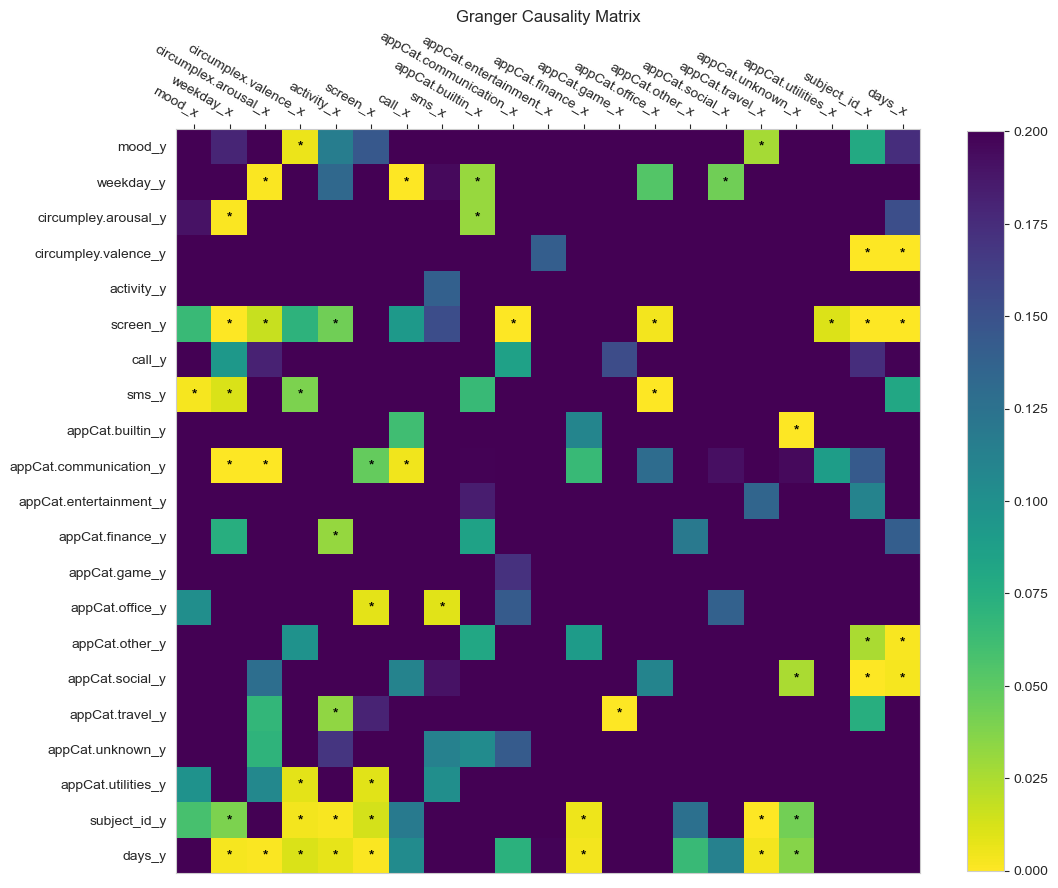

In [85]:


labels_len = len(granger_matrix.columns)
np_granger = np.array(granger_matrix)
fig, ax = plt.subplots(figsize=(12,12))
heatmap = ax.imshow(np_granger, vmax=0.2,cmap="viridis_r")

for i in range(labels_len):
    for j in range(labels_len):
        text = ax.text(j, i, "*" if np_granger[i, j] < 0.05 else "",
                       ha="center", va="center", color="black",weight="bold" )

cbar = ax.figure.colorbar(heatmap, ax=ax, shrink=0.8)

ax.set_xticks(np.arange(labels_len))
ax.set_yticks(np.arange(labels_len))
ax.set_xticklabels(granger_matrix.columns)
ax.set_yticklabels([i.replace("x","y") for i in list(granger_matrix.columns)])
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")
ax.set_title("Granger Causality Matrix")
plt.savefig("granger_matrix.png", bbox_inches="tight", dpi=300)
